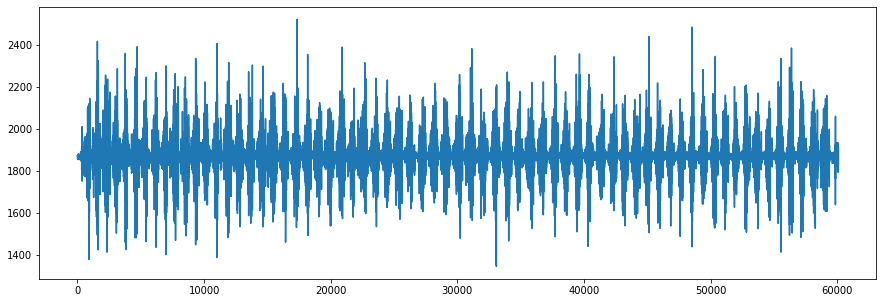

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax, mean
import math
from numpy import arange, sin, pi, random
import tensorflow as tf
import keras
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from numpy import arange, sin, pi, random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.integrate as integrate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr

fs = 1000
dir = os.path.join(os.path.realpath(''),'Data/20200520_18h35m_HongNhung_run.txt')
emg_raw = []

with open(dir) as f:
    lines = f.readlines()
for l in lines:
    emg_raw.append(float(l.replace("\n","")))
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
plt.plot(emg_raw)
plt.show()

wave1 500


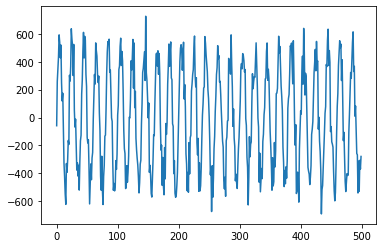

In [33]:
t = arange(0.0, 50.0, 0.1)
wave1 = 500*sin(2 * 0.5 * pi * t)
noise = random.normal(0, 100, len(t))
wave1 = wave1 + noise
print("wave1", len(wave1))
plt.plot(wave1)

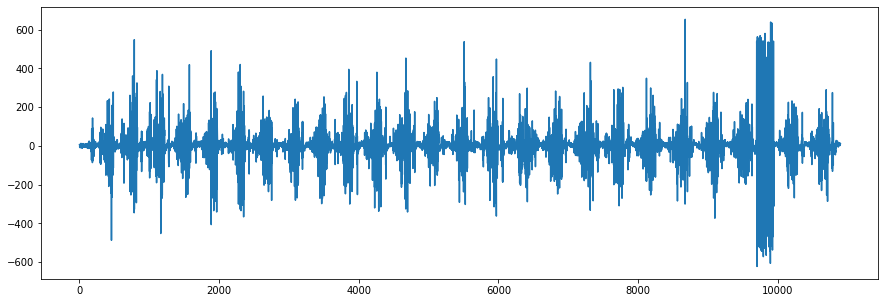

10900


In [50]:
emg_detrend = emg_raw - mean(emg_raw)
data_raw = np.concatenate((np.array(emg_detrend[0:19395]),wave1,np.array(emg_detrend[19395:21300])))
data = []
for i in range(0,len(data_raw)):
    if i%2==0:
        data.append(data_raw[i])
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
plt.plot(data)
plt.show()
print(len(data))

In [51]:
from sklearn.model_selection import train_test_split
def z_norm(result):
    result = np.array(result)
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    print("Length of Data", len(data))

    # train data
    print ("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x sequence length x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)



def kde_sklearn(x, bandwidth=0.2, **kwargs):
	x_grid = np.linspace(x.min() - 0.9*x.min(), x.max() + x.max(), 500)
	"""Kernel Density Estimation with Scikit-learn"""
	kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
	kde_skl.fit(x[:, np.newaxis])
	# score_samples() returns the log-likelihood of the samples
	log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
	return np.exp(log_pdf), x_grid
   
def FindThreshold(x,h,p):
    tau=0
    x.sort() 
    for i in range(len(x)):
        int_K = integrate.quad(lambda s: (1/(h*np.sqrt(2*np.pi)))*np.exp(-0.5*(s-p)/h), (i-1)/len(x), i/len(x))
        tau=tau+int_K[0]*x[i]
    return tau


In [57]:
# train on first 7000 samples and test on next 3000 samples (has anomaly)
sequence_length = 100
DATA_SPLIT_PCT = 0.2
SEED = 123 #used to help randomly select the data points
batch_size = 50
epochs = 10
#X_train,y_train, X_test, y_test = get_split_prep_data(0, 6999, 7000, 10000)
X_train,y_train, X_test, y_test = get_split_prep_data(0, 8799, 8800, 10900)
X_train_X, X_valid = train_test_split(X_train, test_size=DATA_SPLIT_PCT, shuffle=False)
timesteps =  X_train.shape[1] # equal to the sequence_length
n_features =  X_train.shape[2] # 1
print(n_features)

Length of Data 10900
Creating train data...
Mean of train data :  0.5215106408658331
Train data shape  :  (8699, 100)
Creating test data...
Mean of test data :  0.4655322889662913
Test data shape  :  (2000, 100)
Shape X_train (8699, 99)
Shape X_test (2000, 99)
1


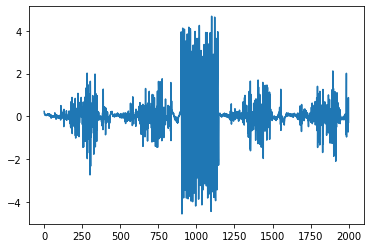

In [58]:
plt.plot(X_test[:,0])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 99, 100)           40800     
_________________________________________________________________
lstm_49 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 99, 25)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 99, 25)            5100      
_________________________________________________________________
lstm_51 (LSTM)               (None, 99, 100)           50400     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 99, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable params: 0
_______________________________________________

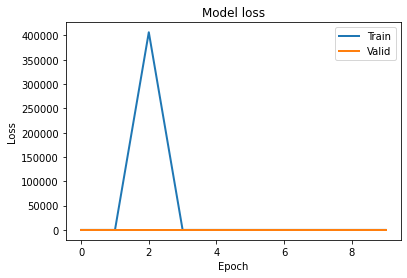

In [59]:

import keras
import sklearn
from sklearn.model_selection import GridSearchCV
results = {}


            # build network
lstm_autoencoder = Sequential()
            # Encoder
lstm_autoencoder.add(LSTM(100, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(25, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
            # Decoder
lstm_autoencoder.add(LSTM(25, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(100, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))
lstm_autoencoder.summary()
lstm_autoencoder.compile(optimizer='adam', loss='mae')
lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch_size, 
                                                validation_split = 0.2,
                                                verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
                                                
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#Best parameters: num_cells=64,  lr=0.01
#num_cells=64
#lr = 0.01

Predicting...


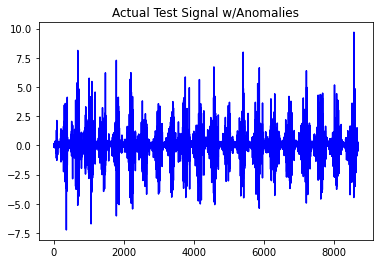

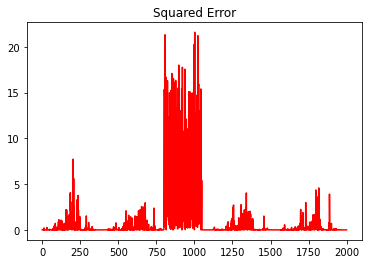

In [60]:
print("Predicting...")
predicted_train = lstm_autoencoder.predict(X_train)
predicted = lstm_autoencoder.predict(X_test)
#print("Reshaping predicted")
#predicted_train = np.reshape(predicted_train, (predicted_train.size,))
#predicted = np.reshape(predicted, (predicted.size,))

plt.figure()
plt.title("Actual Test Signal w/Anomalies")
plt.plot(y_train[:len(y_train)], 'b')

plt.figure()
plt.title("Squared Error")
mse = np.mean(np.power(flatten(X_test) - flatten(predicted), 2), axis=1)
plt.plot(mse, 'r')
mse_train = np.mean(np.power(flatten(X_train) - flatten(predicted_train), 2), axis=1)



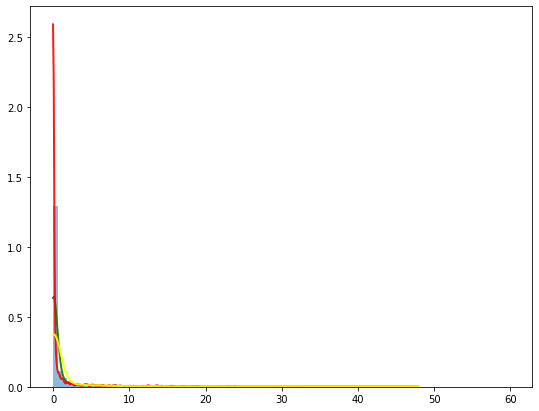

best bandwidth: 0.2222222222222222
Tau :  0.803147067941312
Precision :  0.7
Recall:  0.7888730385164051
Accuracy :  0.5951629863301787
F1_score:  0.4025221890956444


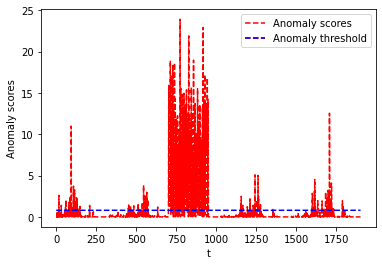

In [48]:
from sklearn.neighbors import KernelDensity
def kde_sklearn(x, bandwidth=0.2, **kwargs):
	x_grid = np.linspace(x.min() - 0.9*x.min(), x.max() + x.max(), 500)
	"""Kernel Density Estimation with Scikit-learn"""
	kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
	kde_skl.fit(x[:, np.newaxis])
	# score_samples() returns the log-likelihood of the samples
	log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
	return np.exp(log_pdf), x_grid
   
def FindThreshold(x,h,p):
    tau=0
    x.sort() 
    for i in range(len(x)):
        int_K = integrate.quad(lambda s: (1/(h*np.sqrt(2*np.pi)))*np.exp(-0.5*(s-p)/h), (i-1)/len(x), i/len(x))
        tau=tau+int_K[0]*x[i]
    return tau

#Plot histogram
fig, ax2 = plt.subplots(figsize = (9,7))
ax2.hist(mse_train, bins = 100, alpha = 0.5, density = True)

#Plot KDE
pdf, mse_grid = kde_sklearn(mse, bandwidth = 0.5)
pdf2, mse_grid2 = kde_sklearn(mse, bandwidth = 0.1)
pdf3, mse_grid3 = kde_sklearn(mse, bandwidth = 0.9)
ax2.plot(mse_grid, pdf, alpha = 0.9, color = 'green', linewidth = 2.0)
ax2.plot(mse_grid2, pdf2, alpha = 0.9, color = 'red', linewidth = 2.0)
ax2.plot(mse_grid3, pdf3, alpha = 0.9, color = 'yellow', linewidth = 2.0)
plt.show()

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.linspace(0, 0.5, 10)}
grid = GridSearchCV(KernelDensity(), params, cv = 20)
grid.fit(mse_train[:, None])

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
h=grid.best_estimator_.bandwidth
tau=FindThreshold(mse_train,h,0.56)

y_test1=np.ones(X_test.shape[0])
y_test1[999:1499]=-1
y_scores=np.ones(X_test.shape[0])
y_scores[(mse-tau)>0]=-1
precision = precision_score(y_test1, y_scores)
recall    = recall_score(y_test1, y_scores)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, average='macro')
print ('Tau : ', tau)
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('Accuracy : ', accuracy)
print ('F1_score: ', f1)
fig=plt.figure(4)
red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*tau, 'b--')
plt.xlabel('t')
plt.ylabel('Anomaly scores')
plt.legend([red_dot, (red_dot, white_cross)], ["Anomaly scores", "Anomaly threshold"])
plt.show()
fig.savefig('plot.png', dpi=1200)